Attempt to refactor/analyze winning model. See discussion on http://forums.fast.ai/t/corporacion-favorita-grocery-sales-forecasting/8359/81

## Load libraries

In [1]:
gpu=0
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=$gpu
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os,sys
sys.path.insert(1, '/home/kevin/fastai') #make a simlink to the code folder
from fastai.structured import *
from fastai.column_data import *
from IPython.display import HTML
np.set_printoptions(threshold=50, edgeitems=20)
from datetime import date, timedelta

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


## Functions

In [2]:
#paths
data_path = '/home/kevin/nbs/kaggle/GrocerySales/data/'
slowdata = data_path + 'slowdisk/'; slowdata
simple = slowdata + 'replicate_winner/'
#leaves duplicate field names on left and appends with _y on right
def join_df(left, right, left_on, right_on=None):
    if right_on is None: right_on=left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, suffixes=("", "_y"))

In [3]:
#normalize and denormalize targets
def normy(y):
    meany=np.mean(y)
    stdevy = np.std(y)
    ynorm = (y-meany)/stdevy
    return meany, stdevy, ynorm

def denorm(y, meany, stdevy, r=3):
    return np.round(y*stdevy+meany, r)

#
def trainable_params(m):
    model_parameters = filter(lambda p: p.requires_grad, m.model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

def mae(inp, targ):
    inp = inp.view(inp.numel())
    targ = targ.view(targ.numel())
    l = len(inp)
    return torch.sum(torch.abs(inp-targ))/l

#custom function I wrote to add a null check
def apply_cats(df, trn, null_check=False):
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)
            if null_check and df[n].isnull().values.any():
                raise ValueError(f'Target dataframe has null values for column {n}. This can occur if the target dataframe has category values not present in original.')

## Load and clean data

In [4]:
# specify datatypes before loading the data will save you a ton of memory.
dtypes = {'id': np.uint32,
          'store_nbr': np.uint8, 
          'item_nbr': np.uint32, 
          'unit_sales': np.float32,
          'class': np.uint16,
          'onpromotion': np.bool,
          'dcoilwtico':np.float16,
          'transactions':np.uint16,
          'cluster': np.uint32}

In [5]:
train = pd.read_csv(slowdata + 'train.csv', dtype=dtypes, usecols=[1,2,3,4,5], parse_dates=['date'],
                    skiprows=range(1, 86672217) #Skip dates before 2016-08-01, and id column
                   )
test = pd.read_csv(slowdata + 'test.csv', dtype=dtypes, parse_dates=['date'])
items = pd.read_csv(slowdata + 'items.csv', dtype=dtypes)
stores = pd.read_csv(slowdata + 'stores.csv', dtype=dtypes)

In [6]:
# data older than march 1 showed no improvement. Setting to Jan so code works.
train = train[train['date'] >= '2017-01-01']

In [7]:
train['unit_sales'] = train['unit_sales'].as_matrix().clip(min=0) # get rid of negs
train['unit_sales'] =  train['unit_sales'].apply(pd.np.log1p) # transform for smoother training
train['onpromotion'].fillna(False, inplace=True) # fill in the missing promotion data with 'False'
test['onpromotion'].fillna(False, inplace=True)

In [8]:
items.set_index('item_nbr', inplace=True)
stores.set_index('store_nbr', inplace=True)

#### Save and load cleaned data

In [9]:
train.to_pickle(simple + 'train_processed.pkl')
test.to_pickle(simple + 'test_processed.pkl')
items.to_pickle(simple + 'items_processed.pkl')
stores.to_pickle(simple + 'stores_processed.pkl')

lastdate = test.iloc[test.shape[0]-1].date

## Build DFs

In [4]:
train = pd.read_pickle(simple + 'train_processed.pkl')
test = pd.read_pickle(simple + 'test_processed.pkl')
items = pd.read_pickle(simple + 'items_processed.pkl')
stores = pd.read_pickle(simple + 'stores_processed.pkl')

##### Sales DF

In [5]:
sales_df = train.set_index(
    ['store_nbr', 'item_nbr', 'date'])[['unit_sales']].unstack(level=-1).fillna(0)
sales_df.columns = sales_df.columns.get_level_values(1)

##### Items and Stores

In [6]:
#now items and stores are dataframes of sales_df length
items_df = items.reindex(sales_df.index.get_level_values(1))
stores_df = stores.reindex(sales_df.index.get_level_values(0))

##### Promo dataframe prep

In [7]:
promo_train_df = train.set_index(
    ['store_nbr', 'item_nbr', 'date'])[['onpromotion']].unstack(level=-1).fillna(False)
promo_train_df.columns = promo_train_df.columns.get_level_values(1)
promo_test_df = test.set_index(
    ['store_nbr', 'item_nbr', 'date'])[['onpromotion']].unstack(level=-1).fillna(False)
promo_test_df.columns = promo_test_df.columns.get_level_values(1)
tr_idx = promo_train_df.index
promo_test_df = promo_test_df.reindex(tr_idx).fillna(False)
promo_df = pd.concat([promo_train_df, promo_test_df], axis=1)

##### Sales item and promo item

In [8]:
sales_item_df = sales_df.groupby('item_nbr').sum() #sum of unit sales for each item across all stores
promo_item_df = promo_df.groupby('item_nbr').sum() #sum of promotions

##### Sales store class and promo store class

In [6]:
sales_store_class_df = sales_df.reset_index()
sales_store_class_df['class'] = items_df['class'].values
sales_store_class_index = sales_store_class_df[['class', 'store_nbr']]
#train.columns to ensure only date columns returned
sales_store_class_df = sales_store_class_df.groupby(['class', 'store_nbr'])[sales_df.columns].sum()

In [10]:
#repeat for promos
promo_store_class_df = promo_df.reset_index()
promo_store_class_df['class'] = items_df['class'].values
promo_store_class_index = promo_store_class_df[['class', 'store_nbr']] #for ...?
promo_store_class_df = promo_store_class_df.groupby(['class', 'store_nbr'])[promo_df.columns].sum()

#### Save dfs

In [7]:
sales_df.to_pickle(simple + 'sales_df.pkl')
promo_df.to_pickle(simple + 'promo_df.pkl')
items_df.to_pickle(simple + 'items_df.pkl')
stores_df.to_pickle(simple + 'stores_df.pkl')
sales_store_class_index.to_pickle(simple + 'sales_store_class_index.pkl')
sales_item_df.to_pickle(simple + 'sales_item_df.pkl')
promo_item_df.to_pickle(simple + 'promo_item_df.pkl')
sales_store_class_df.to_pickle(simple + 'sales_store_class_df.pkl')
promo_store_class_df.to_pickle(simple + 'promo_store_class_df.pkl')

## Build features

#### Load dfs

In [4]:
train = pd.read_pickle(simple + 'train_processed.pkl')
test = pd.read_pickle(simple + 'test_processed.pkl')
items = pd.read_pickle(simple + 'items_processed.pkl')
stores = pd.read_pickle(simple + 'stores_processed.pkl')

In [5]:
#train = pd.read_pickle(simple + 'train_processed.pkl')
sales_df = pd.read_pickle(simple + 'sales_df.pkl')
promo_df = pd.read_pickle(simple + 'promo_df.pkl')
items_df = pd.read_pickle(simple + 'items_df.pkl')
stores_df = pd.read_pickle(simple + 'stores_df.pkl')
sales_store_class_index = pd.read_pickle(simple + 'sales_store_class_index.pkl')
sales_item_df = pd.read_pickle(simple + 'sales_item_df.pkl')
promo_item_df = pd.read_pickle(simple + 'promo_item_df.pkl')
sales_store_class_df = pd.read_pickle(simple + 'sales_store_class_df.pkl')
promo_store_class_df = pd.read_pickle(simple + 'promo_store_class_df.pkl')

In [6]:
prediction_days = (test.iloc[-1].date - test.iloc[0].date).days + 1; prediction_days

16

In [7]:
m_items_df = items_df.reset_index()
m_stores_df= stores_df.reset_index()

In [8]:
#save mem
del train

In [9]:
def get_df_timespan(df, dt, minus, periods, freq='D'):
    r = pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)
    return df[r]

In [15]:
def prepare_dataset(df, promo_df, start_date, is_train=True, name_prefix=None, prediction_days=prediction_days):
    X=pd.DataFrame()
    
    for i in [1, 7, 14, 40]:
        X[f'promos_{i}_before'] = get_df_timespan(promo_df, start_date, i, i).sum(axis=1).values
    
    for i in [3, 7, 14]:
        X[f'promo_{i}_after'] = get_df_timespan(promo_df, start_date + timedelta(prediction_days), 
                                                prediction_days-1, i).sum(axis=1).values
    
    for i in [3, 7, 14, 30, 40]:
        tmp = get_df_timespan(df, start_date, i, i)
        X[f'mean_{i}_before'] = tmp.mean(axis=1).values
        X[f'mean_{i}_diff_before'] = tmp.diff(axis=1).mean(axis=1).values
        X[f'min_{i}_before'] = tmp.min(axis=1).values
        X[f'max_{i}_before'] = tmp.max(axis=1).values
        X[f'std_{i}_before'] = tmp.std(axis=1).values
        X[f'sum_{i}_before'] = tmp.sum(axis=1).values
        
    for i in [3, 7, 14, 30, 40]:
        tmp = get_df_timespan(df, start_date, i, i)        
        X[f'has_sales_days_in_last_{i}'] = (tmp > 0).sum(axis=1).values
        X[f'last_has_sales_day_in_last_{i}'] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values
        X[f'first_has_sales_day_in_last_{i}'] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values
        
        tmp = get_df_timespan(promo_df, start_date, i, i)
        X[f'has_promo_days_in_last_{i}'] = (tmp > 0).sum(axis=1).values
        X[f'last_has_promo_day_in_last_{i}'] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values
        X[f'first_has_promo_day_in_last_{i}'] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values

    for i in range(1, 16):
        X['sales_{i}_days_ago'] = get_df_timespan(df, start_date, i, 1).values.ravel()
    
    #Day of week
    for i in range(7):
        for j in [14, 7, 3, 1]:
            X[f'mean_{j}_dow_{i}_bfore'] =\
            get_df_timespan(df, start_date, j*7-i, j, freq='7D').mean(axis=1).values
    
    #date categories. Put all categoricals below.
    X['day'] = start_date.day
    X['dow'] = start_date.weekday() 
    X['month'] = start_date.month
    
    for i in range(-16,16):
        X[f'onpromotion_at_{i}_days'] = \
        promo_df[start_date + timedelta(days=i)].values.astype(np.uint8)
    
    if is_train:
        prediction_range = pd.date_range(start_date, periods=prediction_days)
        y = df[prediction_range].values
        return X, y

    if name_prefix is not None:
        X.columns = [f'{name_prefix}_{c}' for c in X.columns]
    return X

In [16]:
start_training_from = date(2017, 4, 29)
valid_date = date(2017, 7, 16)
training_weeks = 10 #ends June 28
dates = [start_training_from + timedelta(days=6*d) for d in range(training_weeks+1)]
dates.extend((date(2017, 7, 31), valid_date)) #last date is validation set
X_l, y_l = [], []

for start_date in dates:
    X_tmp, y_tmp = prepare_dataset(sales_df, promo_df, start_date)

    X_tmp2 = prepare_dataset(sales_item_df, promo_item_df, start_date, 
                             is_train=False, name_prefix='item')
    X_tmp2.index = sales_item_df.index #changes back to items
    X_tmp2 = X_tmp2.reindex(sales_df.index.get_level_values(1)).reset_index(drop=True)
    #now len, index same as X_tmp.
    
    X_tmp3 = prepare_dataset(sales_store_class_df, promo_store_class_df, start_date, 
                             is_train=False, name_prefix='store_class')
    X_tmp3.index = sales_store_class_df.index
    X_tmp3 = X_tmp3.reindex(sales_store_class_index).reset_index(drop=True)
    
    X_tmp = pd.concat([X_tmp, X_tmp2, X_tmp3, m_items_df, m_stores_df], axis=1)
    X_tmp['date_index'] = dates.index(start_date)
    
    X_l.append(X_tmp)
    y_l.append(y_tmp)

X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l; del y_l; del X_tmp; del X_tmp2; del X_tmp3

train_size = int((len(X_train)*(len(dates)-1))/len(dates))
val_idx = list(range(train_size, len(X_train)))

In [20]:
X_train.reset_index(inplace=True, drop=True)

In [23]:
X_train.to_feather(simple + 'X_train.ftr')
pickle.dump(y_train, open(simple + 'y_train.pkl', 'wb')) 
pickle.dump(val_idx, open(simple + 'val_idx.pkl', 'wb')) 

# Restart

Start here after kernel dies

In [1]:
gpu=0
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=$gpu
%matplotlib inline 
# %reload_ext autoreload
# %autoreload 2
import os,sys
sys.path.insert(1, '/home/kevin/fastai')
from fastai.structured import *
from fastai.column_data import *
from IPython.display import HTML
from datetime import date, timedelta

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


## Functions

In [2]:
#paths
data_path = '/home/kevin/nbs/kaggle/GrocerySales/data/'
slowdata = data_path + 'slowdisk/'; slowdata
simple = slowdata + 'replicate_winner/'
#leaves duplicate field names on left and appends with _y on right
def join_df(left, right, left_on, right_on=None):
    if right_on is None: right_on=left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, suffixes=("", "_y"))

In [3]:
#normalize and denormalize targets
def normy(y):
    meany=np.mean(y)
    stdevy = np.std(y)
    ynorm = (y-meany)/stdevy
    return meany, stdevy, ynorm

def denorm(y, meany, stdevy, r=3):
    return np.round(y*stdevy+meany, r)

#
def trainable_params(m):
    model_parameters = filter(lambda p: p.requires_grad, m.model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

def mae(inp, targ):
    inp = inp.view(inp.numel())
    targ = targ.view(targ.numel())
    l = len(inp)
    return torch.sum(torch.abs(inp-targ))/l

#custom function I wrote to add a null check
def apply_cats(df, trn, null_check=False):
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)
            if null_check and df[n].isnull().values.any():
                raise ValueError(f'Target dataframe has null values for column {n}. This can occur if the target dataframe has category values not present in original.')

In [24]:
X_train = pd.read_feather(simple + 'X_train.ftr')
y_train = pickle.load(open(simple + 'y_train.pkl', 'rb'))
val_idx = pickle.load(open(simple + 'val_idx.pkl', 'rb'))

In [27]:
#cat and conv vars
first_cat = X_train.columns.values.tolist().index('day')
cat_vars = X_train.columns[first_cat:].values.tolist()
for v in cat_vars: 
    X_train[v] = X_train[v].astype('category').cat.as_ordered()
contin_vars = X_train.columns[:first_cat].values.tolist(); contin_vars
for v in contin_vars:
    X_train[v] = X_train[v].astype('float32')
cat_sz = [(c, len(X_train[c].cat.categories)+1) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
n_cont = len(contin_vars)
#normalize target
meany, stdevy, yl = normy(y_train)
max_log_y = np.max(yl)
min_log_y = np.min(yl)
y_range = (min_log_y*1.2, max_log_y*1.2)

In [29]:
X_train['ignore'] = 0 #dummy variable because prod_df requires response variable.

In [30]:
#gen model dataframes
df, _, nas, mapper = proc_df(X_train, 'ignore', do_scale=True)

In [33]:
del X_train; del y_train

In [29]:
# df.reset_index(inplace=True)

In [31]:
# df.to_feather(simple + 'df.ftr')

In [32]:
df = pd.read_feather(simple + 'df.ftr')

In [9]:
bs = int(1e3)
md = ColumnarModelData.from_data_frame(path=simple, val_idxs=val_idx, df=df, y=yl,
                                      cat_flds=cat_vars, bs=bs)

for i in range(2):
    m = md.get_learner(emb_szs=emb_szs, n_cont=n_cont, emb_drop=0.1, 
                   out_sz=16, szs=[512,256,128,64], drops=[.1,.1,.1,.1], y_range=y_range)
    m.crit = mae
    print(f'==============={i}=====================')
    m.warm_up(1e-3)
    m.fit(2e-4,4)
    m.fit(2e-5,2)

In [28]:
m = md.get_learner(emb_szs=emb_szs, n_cont=n_cont, emb_drop=0.5, 
                   out_sz=16, szs=[512,256,128,64], drops=[.5,.5,.5,.5], y_range=y_range)

In [29]:
m.fit(1e-3,2, cycle_len=2, cycle_mult=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss                                 
    0      0.572404   0.374506  
    1      0.518312   0.382381                                 
    2      0.429057   0.40045                                  
    3      0.389929   0.389182                                 
    4      0.372068   0.386812                                 
    5      0.365212   0.382646                                 
    6      0.361541   0.385794                                 
    7      0.35853    0.386254                                 



[0.38625354]

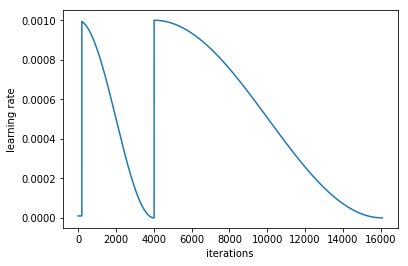

In [22]:
m.sched.plot_lr()

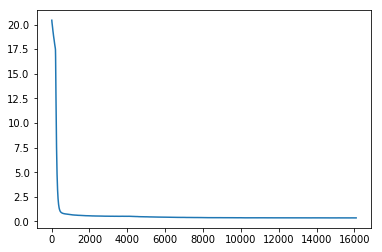

In [30]:
m.sched.plot_loss()

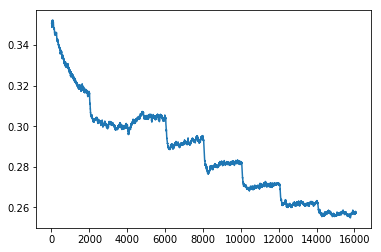

In [25]:
m.sched.plot_loss()

Below is m.fit(2e-4,2, cycle_len=2, cycle_mult=2)

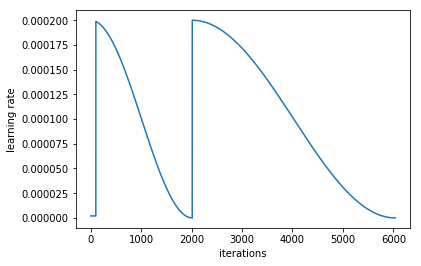

In [113]:
m.sched.plot_lr()

##### m.warm_up??

In [93]:
m.crit = mae
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      1.258426   2.262941  



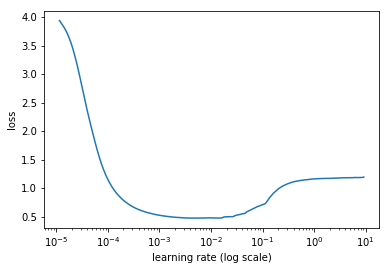

In [94]:
m.sched.plot(10)

###### Notes
+ Increasing number of [dates] improved.
+ Increasing the range of mean improved.
+ Increasing bs from 1000 to 10,000 decreased
+ Decreasing bs from 1000 to 100 decreased
+ Increasing szs to 20,10 did nothing.
+ Increasing szs to 10,5,5 did nothing.
+ Adding promos_i_before might help.
+ Adding promos_i_ after might help.
+ Adding more training dates with dropout seems to prevent the overfitting.
+ Batch size of 2e3 seems to work the best.

###### Large dataset and model
+ Trying .25 dropout to reduce overfitting. Still overfits.

## Random Forests

In [36]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [34]:
((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idx, df, yl)

In [49]:
m_rf = RandomForestRegressor(n_estimators = 20, min_samples_leaf=1000, n_jobs=-1)

In [50]:
#speeds up since scikt-learn code calls this function.
x = np.array(trn_df, dtype=np.float32)

In [51]:
%time m_rf.fit(x, trn_y)

CPU times: user 3h 29min 41s, sys: 1.13 s, total: 3h 29min 43s
Wall time: 22min 17s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1000, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [52]:
m_rf.score(trn_df, trn_y)

0.6575779499725225

In [70]:
m_rf.score(val_df, val_y)

0.65008719278136762

In [73]:
feat_imp2 = pd.DataFrame({'score': m_rf.feature_importances_, 'feature': df.columns })
feat_imp2.sort_values('score', axis=0, ascending=False, inplace=True)
top_features = feat_imp2[feat_imp2['score'] >= .0001]; 
top_features.reset_index(inplace=True, drop=True)

In [74]:
top_features

,feature,score
0,sum_14_before,0.454851
1,mean_14_before,0.314681
2,mean_30_before,0.061810
3,sum_30_before,0.054516
4,mean_40_before,0.029909
5,sum_40_before,0.028628
6,promo_14_after,0.008888
7,store_class_dow,0.005143
8,dow,0.005110
9,item_dow,0.004356


### Draw tree

In [76]:
n = int(0.1 * len(df))

In [77]:
samp_df = df[n:].copy()
samp_yl = yl[n:].copy()

In [78]:
samp_m = RandomForestRegressor(n_estimators=1, max_depth=4, min_samples_leaf=50, bootstrap=False, n_jobs=-1)

In [79]:
samp_df = np.array(samp_df, dtype=np.float32)

In [80]:
samp_m.fit(samp_df, samp_yl)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=50, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [81]:
samp_m.score(samp_df, samp_yl)

0.61597269369871965

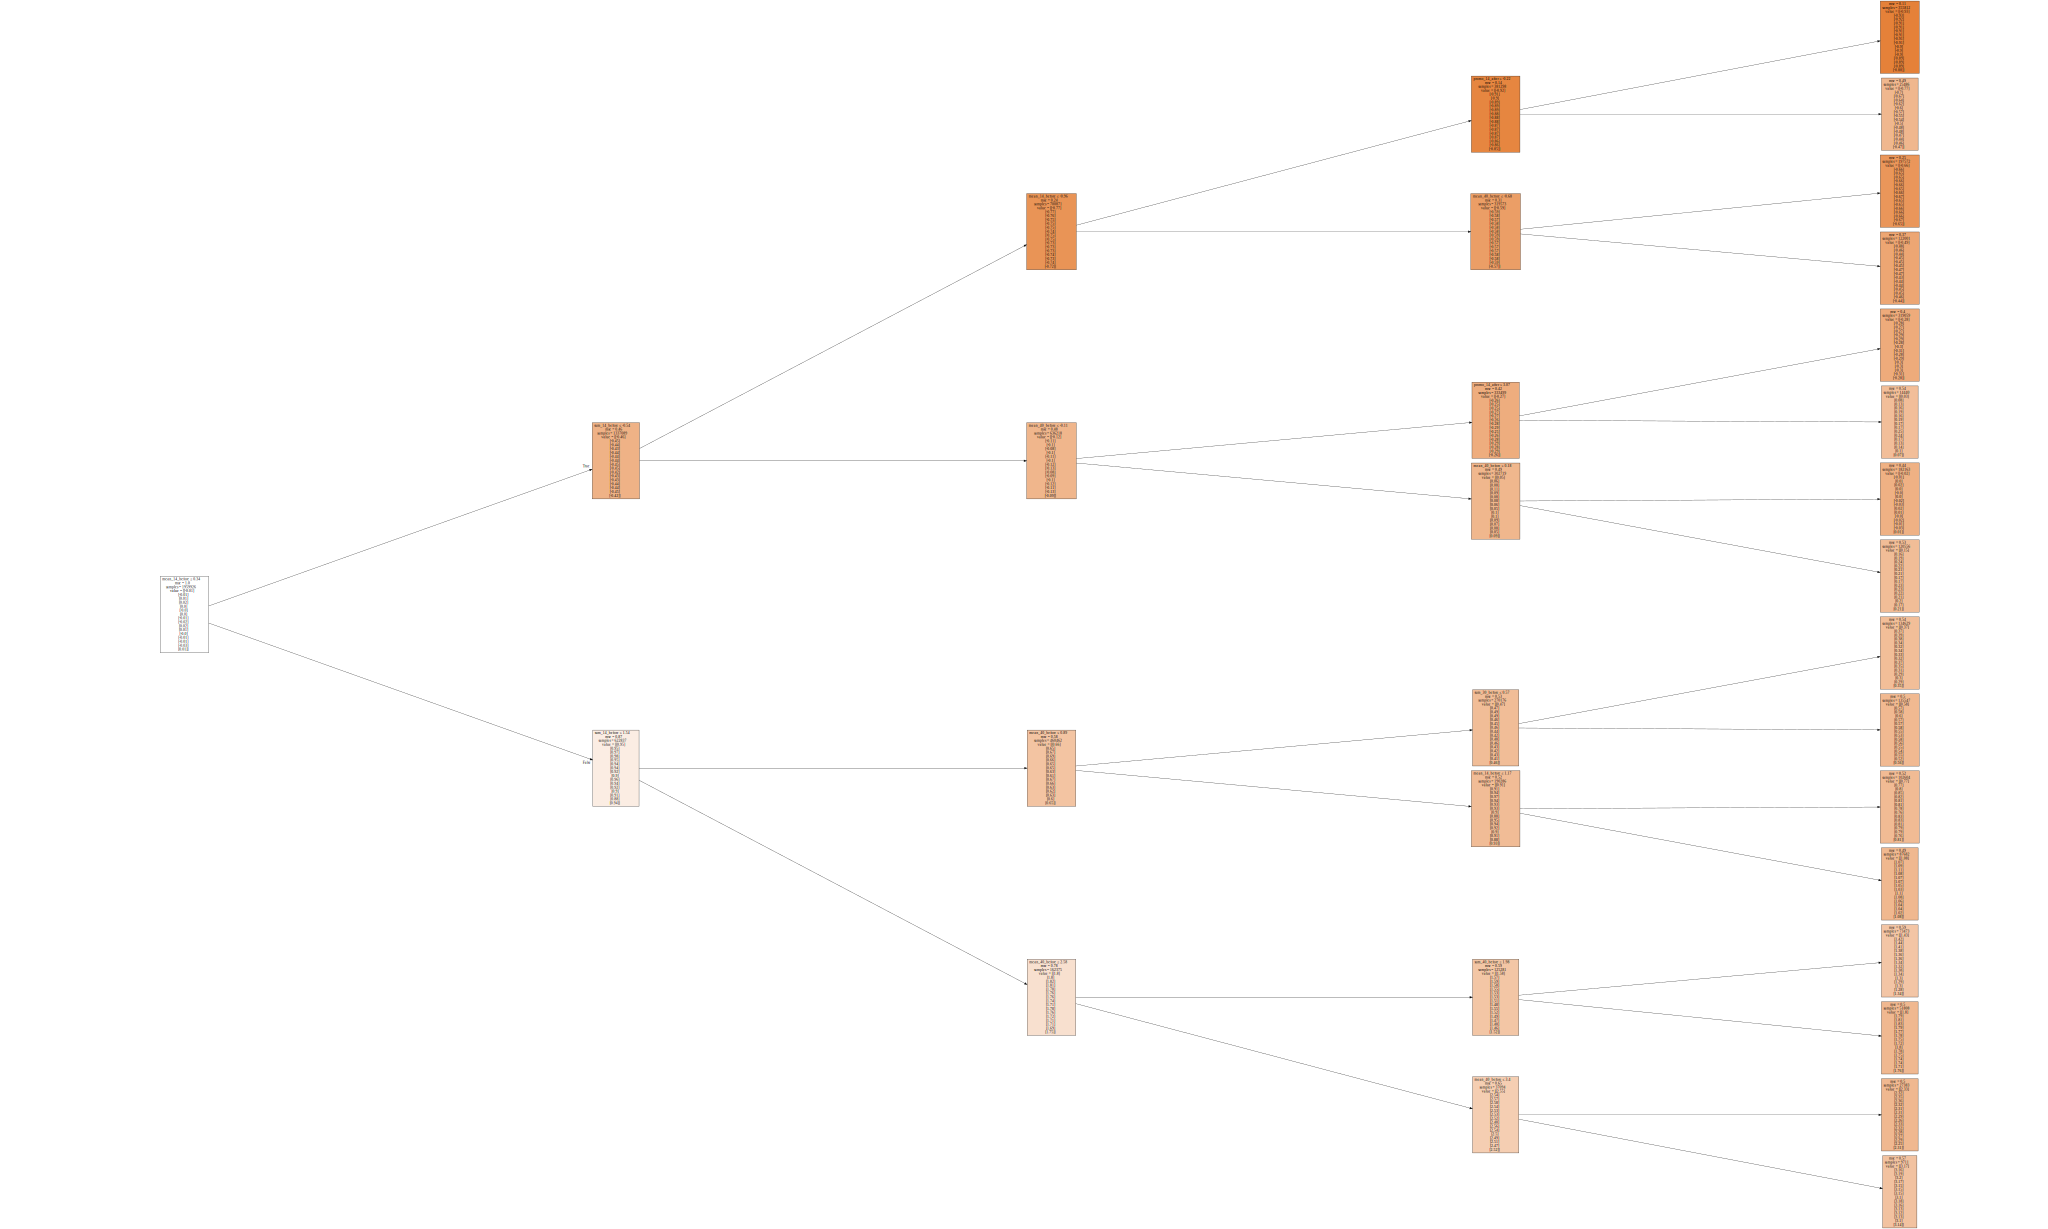

In [85]:
draw_tree(samp_m.estimators_[0], df, size=60, precision=2)

In [83]:
meany

1.0738937

In [84]:
stdevy

1.0724497